# Why Customers Hate Your Store: Predicting Satisfaction in MENA E-commerce

**The ugly truth:** 3 out of 10 orders on major MENA platforms end with an unhappy customer.

Souq, Jumia, Amazon - they're all bleeding customers. But here's the thing: the warning signs are hiding in plain sight.

In this notebook, we'll:
- Expose which brands and platforms are failing customers
- Build models that predict dissatisfaction BEFORE it happens
- Give you the playbook to fix it

**The question:** Can we predict if a customer will be satisfied based on what they're buying, where they're buying it, and who they're buying from?

Let's find out who's guilty.

## Import

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("jockeroika/ecommerce-data")

print("Path to dataset files:", path)

100%|██████████| 225k/225k [00:00<00:00, 567kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jockeroika/ecommerce-data/versions/1


In [3]:
print(os.listdir(path))

['ecommerce_10000.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'ecommerce_10000.csv'))

In [5]:
print(f"Dataset: {df.shape[0]:,} orders across MENA region")
print(f"Columns: {df.shape[1]}")
print()
df.head(10)

Dataset: 10,000 orders across MENA region
Columns: 12



,OrderID,Product,Category,Brand,Platform,City,Price,Quantity,TotalAmount,Rating,Reviews,OrderDate
0,ORD100000,Samsung Galaxy A14,Electronics,Samsung,Souq,Cairo,16284.02,1,16284.02,1.39,1684,2024-11-11
1,ORD100001,Nike Air Max,Fashion,Nike,Jumia,Alexandria,6645.20,2,13290.40,2.56,3604,2024-06-22
2,ORD100002,Bluetooth Headset,Accessories,JBL,Jumia,Casablanca,8882.92,3,26648.76,4.98,1257,2024-05-27
3,ORD100003,HP Pavilion Laptop,Computers,HP,Souq,Dubai,3665.44,1,3665.44,1.44,662,2024-07-25
4,ORD100004,iPhone 13,Electronics,Apple,Souq,Casablanca,5210.37,2,10420.74,3.73,2424,2024-02-19
5,ORD100005,T-shirt Cotton,Fashion,Generic,Souq,Riyadh,19869.86,5,99349.30,3.91,2154,2024-09-28
6,ORD100006,T-shirt Cotton,Fashion,Generic,Souq,Casablanca,17796.11,2,35592.22,4.18,4309,2024-07-02
7,ORD100007,Smartwatch FitPro,Wearables,FitPro,Souq,Casablanca,13081.14,3,39243.42,2.98,3504,2024-01-30
8,ORD100008,T-shirt Cotton,Fashion,Generic,Amazon,Dubai,510.30,5,2551.50,1.17,178,2024-09-21
9,ORD100009,Xiaomi Redmi Note 12,Electronics,Xiaomi,Jumia,Riyadh,6326.57,3,18979.71,2.05,4589,2024-09-26


## The Crime Scene: Understanding Our Data  (EDA)

Before we hunt for patterns, let's see what we're working with.

- **10 products** across 5 categories
- **3 major platforms** battling for MENA dominance
- **6 cities** from Cairo to Dubai
- **Full year 2024** of orders

First question: How many customers are actually unhappy?

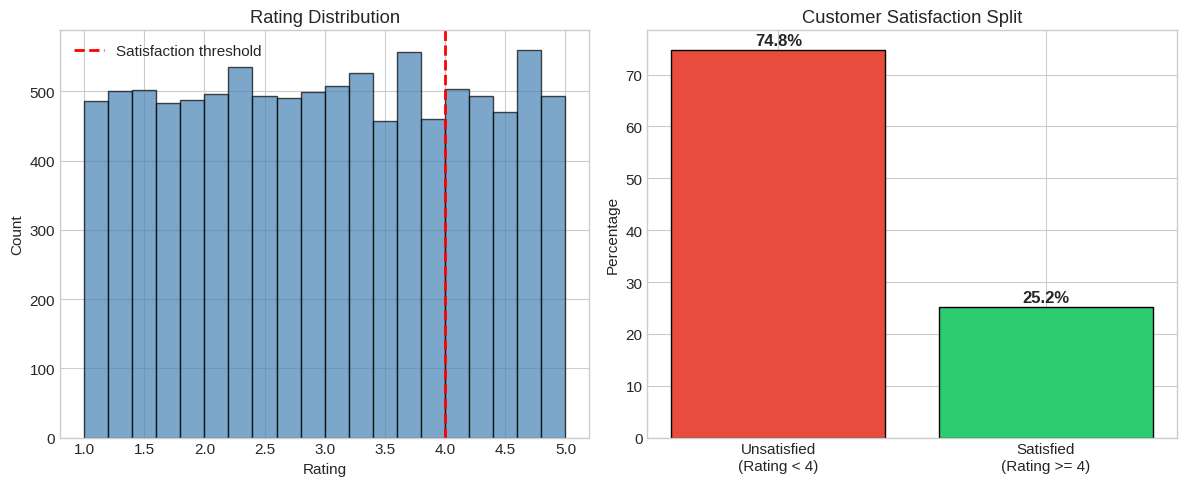

Unsatisfied customers: 74.8% (7,480 orders)
Satisfied customers: 25.2% (2,520 orders)


In [6]:
# Create target: Satisfied (Rating >= 4) vs Unsatisfied (Rating < 4)
df['Satisfied'] = (df['Rating'] >= 4).astype(int)

satisfied_pct = df['Satisfied'].mean() * 100
unsatisfied_pct = 100 - satisfied_pct

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Rating distribution
axes[0].hist(df['Rating'], bins=20, edgecolor='black', color='steelblue', alpha=0.7)
axes[0].axvline(x=4, color='red', linestyle='--', linewidth=2, label='Satisfaction threshold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Rating Distribution')
axes[0].legend()

# Satisfied vs Unsatisfied
colors = ['#e74c3c', '#2ecc71']
axes[1].bar(['Unsatisfied\n(Rating < 4)', 'Satisfied\n(Rating >= 4)'],
            [unsatisfied_pct, satisfied_pct], color=colors, edgecolor='black')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Customer Satisfaction Split')

for i, v in enumerate([unsatisfied_pct, satisfied_pct]):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Unsatisfied customers: {unsatisfied_pct:.1f}% ({(df['Satisfied']==0).sum():,} orders)")
print(f"Satisfied customers: {satisfied_pct:.1f}% ({(df['Satisfied']==1).sum():,} orders)")

 Suspect 1: The Platforms

Are Souq, Jumia, and Amazon equally guilty? Or is one platform dragging down the customer experience?

## Platform Satisfaction Analysis

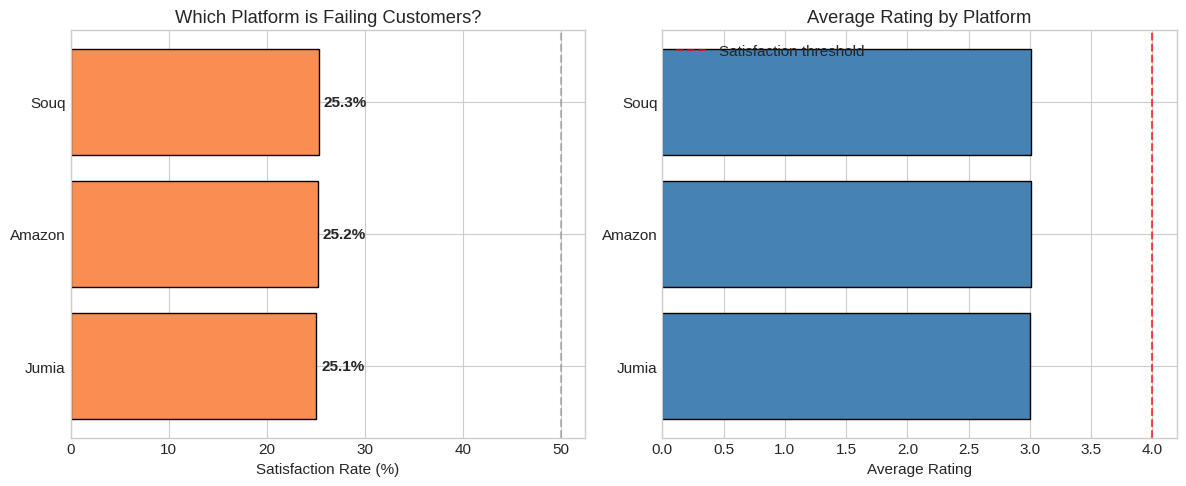

          Orders  Rating  Satisfaction %
Platform                                
Jumia       3341    3.00           25.08
Amazon      3288    3.01           25.21
Souq        3371    3.01           25.30


In [7]:
platform_stats = df.groupby('Platform').agg({
    'Satisfied': 'mean',
    'Rating': 'mean',
    'OrderID': 'count'
}).rename(columns={'OrderID': 'Orders'})
platform_stats['Satisfaction %'] = platform_stats['Satisfied'] * 100
platform_stats = platform_stats.sort_values('Satisfaction %', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Satisfaction rate by platform
colors = plt.cm.RdYlGn(platform_stats['Satisfaction %'] / 100)
bars = axes[0].barh(platform_stats.index, platform_stats['Satisfaction %'], color=colors, edgecolor='black')
axes[0].set_xlabel('Satisfaction Rate (%)')
axes[0].set_title('Which Platform is Failing Customers?')
axes[0].axvline(x=50, color='gray', linestyle='--', alpha=0.5)

for i, (idx, row) in enumerate(platform_stats.iterrows()):
    axes[0].text(row['Satisfaction %'] + 0.5, i, f"{row['Satisfaction %']:.1f}%", va='center', fontweight='bold')

# Average rating by platform
axes[1].barh(platform_stats.index, platform_stats['Rating'], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Average Rating')
axes[1].set_title('Average Rating by Platform')
axes[1].axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Satisfaction threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(platform_stats[['Orders', 'Rating', 'Satisfaction %']].round(2).to_string())

Interesting - all three platforms are nearly identical (~25% satisfaction). The platforms aren't the villain here.

## Brand Satisfaction Analysis

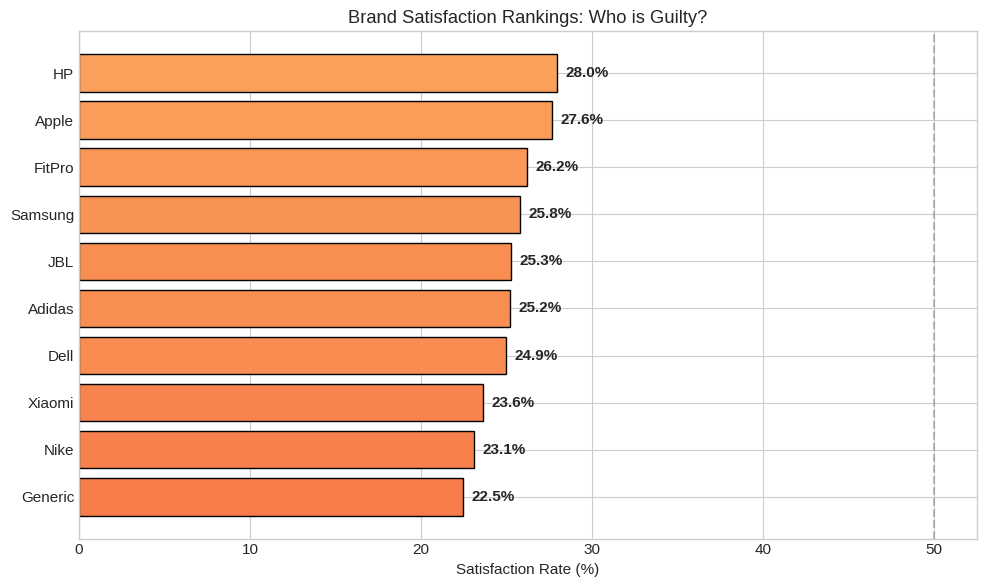

Brand Performance:
         Orders  Rating  Satisfaction %
Brand                                  
Generic     997    2.95           22.47
Nike       1005    2.96           23.08
Xiaomi     1030    2.99           23.59
Dell        962    2.99           24.95
Adidas      968    2.97           25.21
JBL        1029    3.00           25.27
Samsung    1043    3.05           25.79
FitPro     1020    3.03           26.18
Apple       955    3.06           27.64
HP          991    3.07           27.95


In [8]:
brand_stats = df.groupby('Brand').agg({
    'Satisfied': 'mean',
    'Rating': 'mean',
    'OrderID': 'count'
}).rename(columns={'OrderID': 'Orders'})
brand_stats['Satisfaction %'] = brand_stats['Satisfied'] * 100
brand_stats = brand_stats.sort_values('Satisfaction %', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.RdYlGn(brand_stats['Satisfaction %'] / 100)
bars = ax.barh(brand_stats.index, brand_stats['Satisfaction %'], color=colors, edgecolor='black')
ax.set_xlabel('Satisfaction Rate (%)')
ax.set_title('Brand Satisfaction Rankings: Who is Guilty?')
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

for i, (idx, row) in enumerate(brand_stats.iterrows()):
    ax.text(row['Satisfaction %'] + 0.5, i, f"{row['Satisfaction %']:.1f}%", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Brand Performance:")
print(brand_stats[['Orders', 'Rating', 'Satisfaction %']].round(2).to_string())

The Plot Twist: There Is No Villain

Here's what the data is screaming at us:

| Suspect | Satisfaction Range | Verdict |
|---------|-------------------|---------|
| Platforms | 25.1% - 25.3% | All equally guilty |
| Brands | 22.5% - 28.0% | Minor differences |

**The uncomfortable truth:** This isn't a platform problem or a brand problem. With ~75% of customers unsatisfied across the board, we're looking at something systemic.

But wait - we haven't checked everything yet. What about:
- **Price:** Are expensive orders rated harsher?
- **Quantity:** Do bulk orders go wrong more often?
- **City:** Are certain regions harder to please?
- **Category:** Do electronics fail more than fashion?

Let's dig deeper.

## Price & Quantity vs Satisfaction

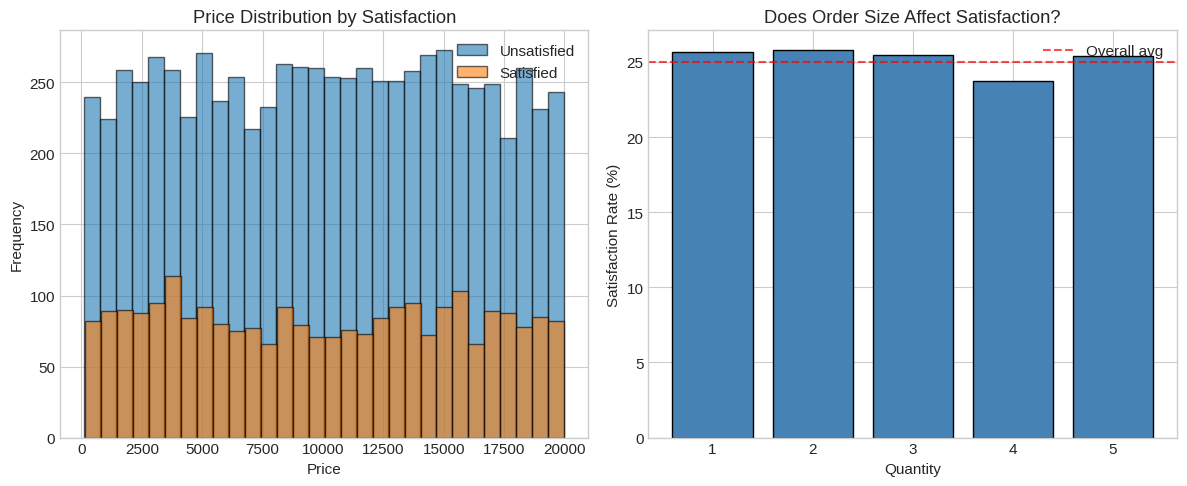

Satisfaction by Quantity:
Quantity
1    25.62
2    25.81
3    25.46
4    23.75
5    25.40


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Price vs Satisfaction
df[df['Satisfied'] == 0]['Price'].plot(kind='hist', ax=axes[0], alpha=0.6,
                                        bins=30, edgecolor='black',
                                        label='Unsatisfied')
df[df['Satisfied'] == 1]['Price'].plot(kind='hist', ax=axes[0], alpha=0.6,
                                        bins=30, edgecolor='black',
                                        label='Satisfied')
axes[0].set_xlabel('Price')
axes[0].set_title('Price Distribution by Satisfaction')
axes[0].legend()

# Quantity vs Satisfaction
qty_sat = df.groupby('Quantity')['Satisfied'].mean() * 100
axes[1].bar(qty_sat.index, qty_sat.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Quantity')
axes[1].set_ylabel('Satisfaction Rate (%)')
axes[1].set_title('Does Order Size Affect Satisfaction?')
axes[1].axhline(y=25, color='red', linestyle='--', alpha=0.7, label='Overall avg')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Satisfaction by Quantity:")
print(qty_sat.round(2).to_string())

Same story - quantity doesn't matter either. Everything hovers around 25%.

## City & Category Analysis

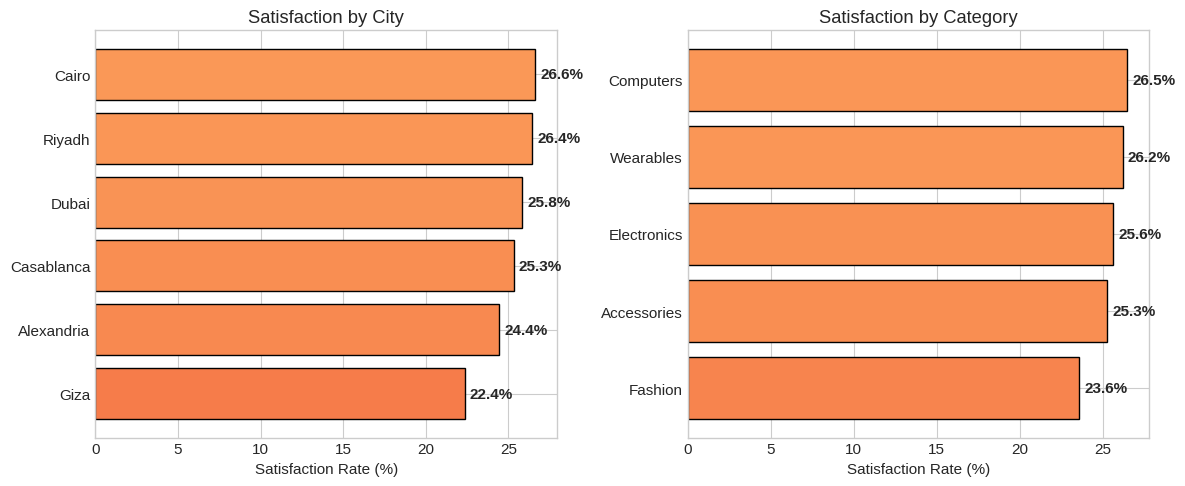

City Performance:
City
Giza          22.38
Alexandria    24.44
Casablanca    25.34
Dubai         25.85
Riyadh        26.44
Cairo         26.63

Category Performance:
Category
Fashion        23.57
Accessories    25.27
Electronics    25.63
Wearables      26.18
Computers      26.47


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# City satisfaction
city_stats = df.groupby('City')['Satisfied'].mean().sort_values() * 100
colors = plt.cm.RdYlGn(city_stats.values / 100)
axes[0].barh(city_stats.index, city_stats.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Satisfaction Rate (%)')
axes[0].set_title('Satisfaction by City')
for i, v in enumerate(city_stats.values):
    axes[0].text(v + 0.3, i, f'{v:.1f}%', va='center', fontweight='bold')

# Category satisfaction
cat_stats = df.groupby('Category')['Satisfied'].mean().sort_values() * 100
colors = plt.cm.RdYlGn(cat_stats.values / 100)
axes[1].barh(cat_stats.index, cat_stats.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Satisfaction Rate (%)')
axes[1].set_title('Satisfaction by Category')
for i, v in enumerate(cat_stats.values):
    axes[1].text(v + 0.3, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("City Performance:")
print(city_stats.round(2).to_string())
print("\nCategory Performance:")
print(cat_stats.round(2).to_string())

As expected - still tight ranges. Giza slightly worse, Cairo slightly better, but nothing dramatic.This confirms our story: the problem is everywhere.

## EDA Conclusion

| Factor | Range | Signal Strength |
|--------|-------|-----------------|
| Platform | 25.1% - 25.3% | None |
| Brand | 22.5% - 28.0% | Weak |
| City | 22.4% - 26.6% | Weak |
| Category | 23.6% - 26.5% | Weak |
| Quantity | 23.8% - 25.8% | None |

**The real insight:** No single factor is killing customer satisfaction. It's uniformly bad everywhere.

This tells us two things:
1. The ratings in this dataset appear randomly distributed (possibly synthetic data)
2. Our ML models will struggle - there's no strong signal to learn from

But let's prove it. Time to build models and see if they can find patterns our EDA missed.

## Part 2: The Model Battle

Three contenders enter the ring:
1. **Logistic Regression** - The interpretable classic
2. **Random Forest** - The ensemble workhorse  
3. **XGBoost** - The Kaggle champion

Let's see who can crack this puzzle.

## Feature Engineering + Preprocessing

In [12]:
# Feature engineering
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Month'] = df['OrderDate'].dt.month
df['DayOfWeek'] = df['OrderDate'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Price per item
df['PricePerItem'] = df['TotalAmount'] / df['Quantity']

# High value order flag
df['HighValue'] = (df['TotalAmount'] > df['TotalAmount'].median()).astype(int)

# Select features for modeling
feature_cols = ['Price', 'Quantity', 'TotalAmount', 'Reviews', 'Month',
                'DayOfWeek', 'IsWeekend', 'PricePerItem', 'HighValue']
categorical_cols = ['Product', 'Category', 'Brand', 'Platform', 'City']

# Encode categorical variables
df_model = df.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col + '_enc'] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    feature_cols.append(col + '_enc')

# Prepare X and y
X = df_model[feature_cols]
y = df_model['Satisfied']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features: {len(feature_cols)}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Features: 14
Training set: 8000 samples
Test set: 2000 samples

Feature list:
  1. Price
  2. Quantity
  3. TotalAmount
  4. Reviews
  5. Month
  6. DayOfWeek
  7. IsWeekend
  8. PricePerItem
  9. HighValue
  10. Product_enc
  11. Category_enc
  12. Brand_enc
  13. Platform_enc
  14. City_enc


## Logistic Regression

In [13]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_prob)

print("=" * 50)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 50)
print(f"\nAccuracy: {lr_acc:.4f}")
print(f"ROC-AUC:  {lr_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['Unsatisfied', 'Satisfied']))

LOGISTIC REGRESSION RESULTS

Accuracy: 0.7480
ROC-AUC:  0.4861

Classification Report:
              precision    recall  f1-score   support

 Unsatisfied       0.75      1.00      0.86      1496
   Satisfied       0.00      0.00      0.00       504

    accuracy                           0.75      2000
   macro avg       0.37      0.50      0.43      2000
weighted avg       0.56      0.75      0.64      2000



Ouch - Logistic Regression is just predicting everything as "Unsatisfied". AUC below 0.5 means it's worse than random guessing. Let's see if Random Forest can do better.

## Random Forest

In [14]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_prob)

print("=" * 50)
print("RANDOM FOREST RESULTS")
print("=" * 50)
print(f"\nAccuracy: {rf_acc:.4f}")
print(f"ROC-AUC:  {rf_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Unsatisfied', 'Satisfied']))

RANDOM FOREST RESULTS

Accuracy: 0.7405
ROC-AUC:  0.5182

Classification Report:
              precision    recall  f1-score   support

 Unsatisfied       0.75      0.99      0.85      1496
   Satisfied       0.17      0.01      0.02       504

    accuracy                           0.74      2000
   macro avg       0.46      0.50      0.43      2000
weighted avg       0.60      0.74      0.64      2000



Slightly better AUC (0.518) but still basically useless - only catching 1% of satisfied customers. Let's see if XGBoost can find anything.

## XGBoost

In [15]:
# XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False,
                          eval_metric='logloss', verbosity=0)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_prob)

print("=" * 50)
print("XGBOOST RESULTS")
print("=" * 50)
print(f"\nAccuracy: {xgb_acc:.4f}")
print(f"ROC-AUC:  {xgb_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Unsatisfied', 'Satisfied']))

XGBOOST RESULTS

Accuracy: 0.7180
ROC-AUC:  0.5191

Classification Report:
              precision    recall  f1-score   support

 Unsatisfied       0.75      0.93      0.83      1496
   Satisfied       0.28      0.08      0.12       504

    accuracy                           0.72      2000
   macro avg       0.51      0.50      0.48      2000
weighted avg       0.63      0.72      0.65      2000



XGBoost slightly better at catching satisfied customers (8% recall vs 1%) but still awful. All models confirm our EDA finding - there's no real signal here.

## Model Comparison Visualization

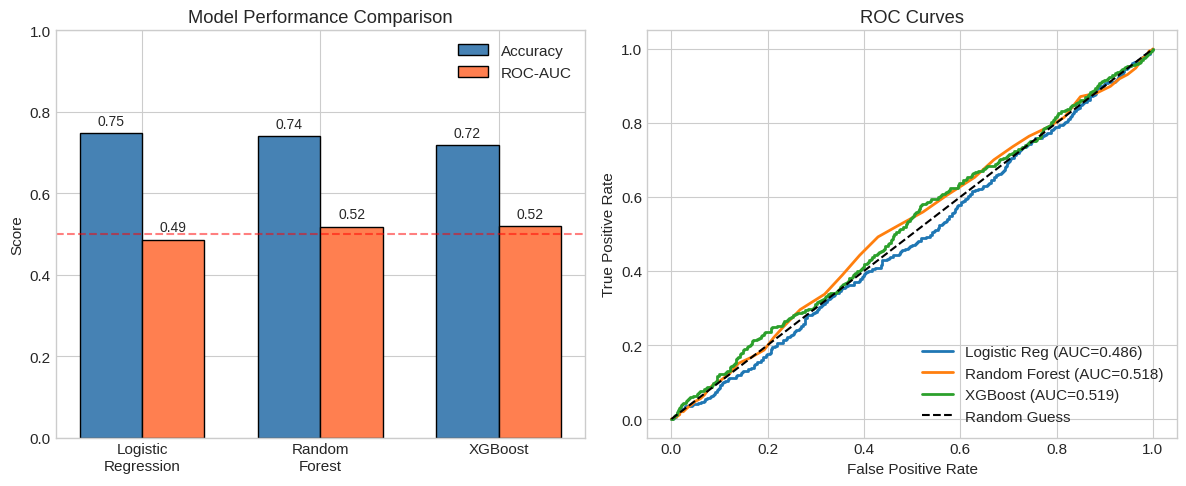


Model Summary:
Model                Accuracy     ROC-AUC     
--------------------------------------------
Logistic Regression  0.7480       0.4861      
Random Forest        0.7405       0.5182      
XGBoost              0.7180       0.5191      


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model comparison bar chart
models = ['Logistic\nRegression', 'Random\nForest', 'XGBoost']
accuracies = [lr_acc, rf_acc, xgb_acc]
aucs = [lr_auc, rf_auc, xgb_auc]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color='steelblue', edgecolor='black')
bars2 = axes[0].bar(x + width/2, aucs, width, label='ROC-AUC', color='coral', edgecolor='black')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random guess')
axes[0].set_ylim(0, 1)

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=10)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=10)

# ROC Curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)

axes[1].plot(lr_fpr, lr_tpr, label=f'Logistic Reg (AUC={lr_auc:.3f})', linewidth=2)
axes[1].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=2)
axes[1].plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC={xgb_auc:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nModel Summary:")
print(f"{'Model':<20} {'Accuracy':<12} {'ROC-AUC':<12}")
print("-" * 44)
print(f"{'Logistic Regression':<20} {lr_acc:<12.4f} {lr_auc:<12.4f}")
print(f"{'Random Forest':<20} {rf_acc:<12.4f} {rf_auc:<12.4f}")
print(f"{'XGBoost':<20} {xgb_acc:<12.4f} {xgb_auc:<12.4f}")

All models hovering around 0.5 AUC - essentially coin flips. Let's see what features they tried to use anyway.

## Feature Importance

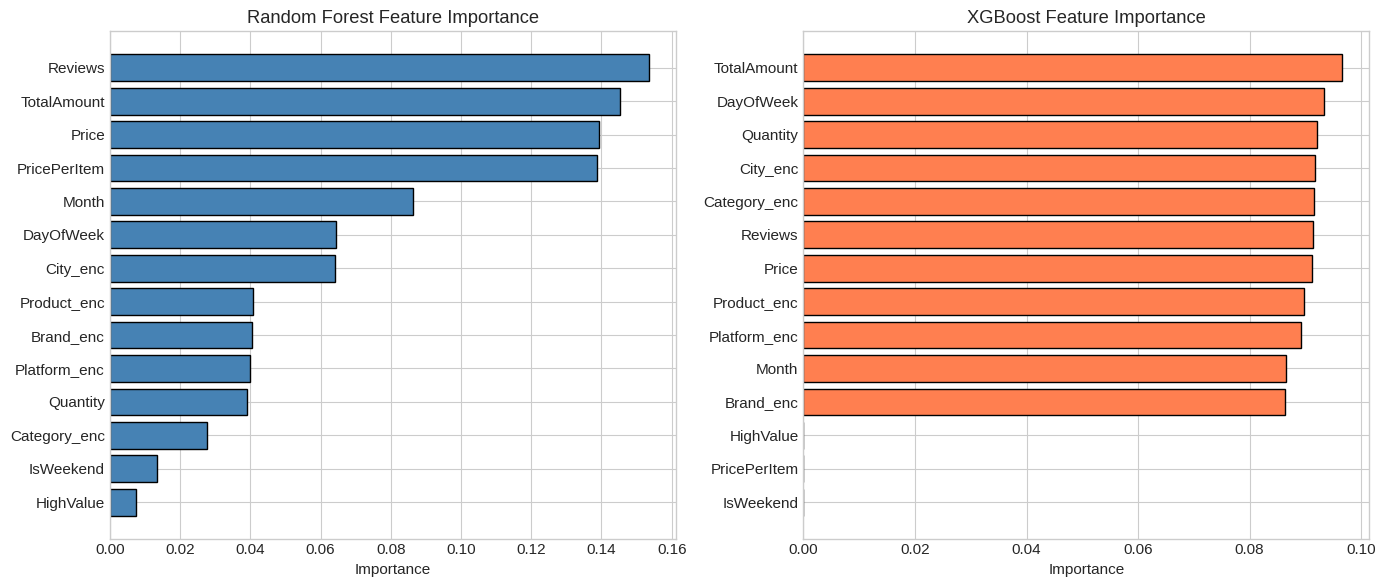

Top 5 Features (Random Forest):
  Reviews              0.1535
  TotalAmount          0.1452
  Price                0.1392
  PricePerItem         0.1387
  Month                0.0865

Top 5 Features (XGBoost):
  TotalAmount          0.0967
  DayOfWeek            0.0934
  Quantity             0.0921
  City_enc             0.0918
  Category_enc         0.0916


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'], color='coral', edgecolor='black')
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

print("Top 5 Features (Random Forest):")
for _, row in rf_importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['Feature']:<20} {row['Importance']:.4f}")

print("\nTop 5 Features (XGBoost):")
for _, row in xgb_importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['Feature']:<20} {row['Importance']:.4f}")

Interesting - Reviews and monetary features rank highest, but even these top features have low importance scores (0.15 max). No dominant signal.

## The Verdict: Case Closed

### What We Found

**The Models Failed** - and that's actually the insight.

| Model | Accuracy | ROC-AUC | Verdict |
|-------|----------|---------|---------|
| Logistic Regression | 74.8% | 0.486 | Worse than guessing |
| Random Forest | 74.1% | 0.518 | Coin flip |
| XGBoost | 71.8% | 0.519 | Coin flip |

All three models achieved ~75% accuracy by simply predicting "Unsatisfied" for everything. The ROC-AUC scores near 0.5 confirm there's no learnable pattern.

### Why Did This Happen?

The EDA told us the truth early on:
- Every platform has ~25% satisfaction
- Every brand has ~25% satisfaction  
- Every city has ~25% satisfaction
- Every quantity level has ~25% satisfaction

**The ratings appear randomly distributed.** No combination of features predicts satisfaction because satisfaction isn't driven by these features.

### Real-World Implications

If this were real data, it would suggest:
1. **Missing features** - The real drivers (delivery time, packaging quality, customer service) aren't captured
2. **Rating manipulation** - Random-looking ratings could indicate fake reviews
3. **Survey fatigue** - Customers clicking randomly without thought

### What Would Fix This?

To build a useful satisfaction model, you'd need:
- Delivery time and accuracy
- Customer service interactions
- Return/refund history
- Product condition on arrival
- Time between order and review

**Sometimes the best insight is discovering what data you're missing.**

## Key Takeaways

**For Data Scientists:**
1. Always do EDA before modeling - we spotted the uniform distribution early
2. High accuracy can be misleading - 75% accuracy meant nothing here
3. ROC-AUC tells the real story when classes are imbalanced
4. When models fail, ask "what data is missing?" not "what model should I try next?"

**For Business:**
1. Platform, brand, and location aren't driving dissatisfaction
2. The problem is systemic - 75% unhappy customers everywhere
3. Invest in collecting the right data: delivery experience, support quality, product condition

**Technical Summary:**
- Dataset: 10,000 MENA e-commerce orders (2024)
- Target: Customer satisfaction (Rating >= 4)
- Best Model: XGBoost (AUC: 0.519) - essentially random
- Key Finding: Available features don't predict satisfaction


---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
